# Part 1.0-1.1: EDA + Classification

In [1]:
""" import os
# depend on where you save the data
os.chdir('./data')
os.getcwd() """

" import os\n# depend on where you save the data\nos.chdir('./data')\nos.getcwd() "

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier




## Load data

In [3]:
orig_df1 = pd.read_csv("data/worldbank_gender_2021.csv")
orig_df1.tail(10)

,Country Name,Year,Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)",Arable land (% of land area),Cereal yield (kg per hectare),Crop production index (2014-2016 = 100),Fertilizer consumption (kilograms per hectare of arable land),Food production index (2014-2016 = 100),...,Merchandise imports (current US$),Merchandise trade (% of GDP),"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)",Firms with female participation in ownership (% of firms),Firms with female top manager (% of firms),"Proportion of time spent on unpaid domestic and care work, female (% of 24 hour day)","Proportion of time spent on unpaid domestic and care work, male (% of 24 hour day)","Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care (% of women age 15-49)",Gender Ratio Class
206,Uruguay,2021,NaN,80.39,7.94,11.60,5499.4,91.17,211.12,100.47,...,1.032000e+10,32.68,1.15,0.60,NaN,NaN,NaN,NaN,NaN,4.0
207,Uzbekistan,2021,14.52,58.30,24.62,9.11,4734.3,102.59,296.84,109.70,...,2.388600e+10,54.57,2.82,2.67,NaN,NaN,NaN,NaN,NaN,3.0
208,Vanuatu,2021,NaN,15.34,NaN,1.64,609.3,84.58,0.01,84.08,...,3.390000e+08,41.35,1.44,1.38,NaN,NaN,NaN,NaN,NaN,4.0
209,"Venezuela, RB",2021,NaN,24.38,NaN,2.95,3505.1,97.18,50.89,88.64,...,7.745000e+09,NaN,1.76,0.74,NaN,NaN,NaN,NaN,NaN,2.0
210,Viet Nam,2021,NaN,39.43,12.60,21.65,5947.1,109.24,427.59,112.81,...,3.320000e+11,182.40,18.52,9.04,NaN,NaN,NaN,NaN,NaN,1.0
211,Virgin Islands (U.S.),2021,NaN,9.43,NaN,2.57,NaN,NaN,NaN,NaN,...,NaN,NaN,0.34,0.21,NaN,NaN,NaN,NaN,NaN,5.0
212,West Bank and Gaza,2021,NaN,64.93,6.32,6.95,2251.9,117.31,371.97,117.39,...,NaN,NaN,8.55,3.44,NaN,NaN,NaN,NaN,NaN,5.0
213,"Yemen, Rep.",2021,NaN,44.42,NaN,2.19,1524.8,124.71,10.63,120.77,...,5.054000e+09,29.68,37.64,9.04,NaN,NaN,NaN,NaN,NaN,1.0
214,Zambia,2021,NaN,32.07,3.00,5.11,2525.0,136.31,63.90,127.49,...,6.435000e+09,74.84,4.87,2.36,NaN,NaN,NaN,NaN,NaN,5.0
215,Zimbabwe,2021,NaN,41.88,8.85,10.34,1545.3,129.97,25.98,120.52,...,7.577000e+09,47.98,0.12,0.11,NaN,NaN,NaN,NaN,NaN,5.0


In [4]:
orig_df2 = pd.read_excel("data/countries_regions.xlsx")
orig_df2.tail(10)

,CountryName,Region,ThirdWorld
207,Uruguay,South America,No
208,Uzbekistan,Western Asia,No
209,Vanuatu,Australia and Oceanea,Yes
210,"Venezuela, RB",South America,No
211,Vietnam,Southeast Asia,No
212,Virgin Islands (U.S.),North America,No
213,West Bank and Gaza,Middle East,No
214,"Yemen, Rep.",Middle East,Yes
215,Zambia,Africa,Yes
216,Zimbabwe,Africa,No


In [5]:
print(orig_df1.shape,orig_df2.shape)

(216, 196) (217, 3)


## Combine Table

In [6]:
missing_countries = orig_df2.loc[
    ~orig_df2['CountryName'].isin(orig_df1['Country Name']),
    'CountryName'
]
missing_countries



37     Central African Republic
206    United States of America
211                     Vietnam
Name: CountryName, dtype: object

In [7]:
name_map = {
    'United States': 'United States of America',
    'Viet Nam': 'Vietnam',

}

orig_df1['Country Name'] = orig_df1['Country Name'].replace(name_map)

In [8]:
missing_countries = orig_df2.loc[
    ~orig_df2['CountryName'].isin(orig_df1['Country Name']),
    'CountryName'
]
missing_countries

37    Central African Republic
Name: CountryName, dtype: object

In [9]:
combined_df = orig_df1.merge(
    orig_df2,
    left_on='Country Name',
    right_on='CountryName',
    how='inner'   
)


In [10]:
combined_df = combined_df.drop(columns=['CountryName'])

In [11]:
combined_df.head(10)

,Country Name,Year,Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)",Arable land (% of land area),Cereal yield (kg per hectare),Crop production index (2014-2016 = 100),Fertilizer consumption (kilograms per hectare of arable land),Food production index (2014-2016 = 100),...,"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)",Firms with female participation in ownership (% of firms),Firms with female top manager (% of firms),"Proportion of time spent on unpaid domestic and care work, female (% of 24 hour day)","Proportion of time spent on unpaid domestic and care work, male (% of 24 hour day)","Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care (% of women age 15-49)",Gender Ratio Class,Region,ThirdWorld
0,Afghanistan,2021,6.51,58.74,33.60,12.00,2099.0,125.67,5.20,114.32,...,60.87,12.79,NaN,NaN,NaN,NaN,NaN,1.0,South Asia,Yes
1,Albania,2021,16.54,41.47,18.36,21.89,5144.7,114.68,NaN,104.92,...,27.58,15.96,NaN,NaN,NaN,NaN,NaN,1.0,Eastern Europe,No
2,Algeria,2021,NaN,17.35,11.23,3.16,1433.7,108.76,20.68,104.83,...,2.10,1.61,NaN,NaN,NaN,NaN,NaN,1.0,Africa,No
3,American Samoa,2021,NaN,14.50,NaN,4.85,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australia and Oceanea,No
4,Andorra,2021,NaN,39.91,0.53,1.59,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Western Europe,No
5,Angola,2021,NaN,36.81,11.49,4.31,1000.1,116.22,5.61,117.50,...,5.59,3.34,NaN,NaN,NaN,NaN,NaN,5.0,Africa,Yes
6,Antigua and Barbuda,2021,NaN,20.45,2.08,9.09,2094.1,81.79,8.33,80.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North America,No
7,Argentina,2021,NaN,43.10,7.31,15.42,5193.0,107.19,62.18,108.40,...,0.85,0.31,NaN,NaN,NaN,NaN,NaN,4.0,South America,No
8,Armenia,2021,9.31,58.83,11.34,15.57,1287.2,71.89,203.73,84.82,...,0.04,0.18,NaN,NaN,NaN,NaN,NaN,5.0,Western Asia,No
9,Aruba,2021,NaN,11.11,NaN,11.11,NaN,NaN,3.86,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North America,No


In [12]:
combined_df.shape

(216, 198)

In [13]:
missing_pct = (combined_df['Gender Ratio Class'].isnull().mean() * 100)
missing_pct

np.float64(13.88888888888889)

## Handling Missing Value

<Axes: >

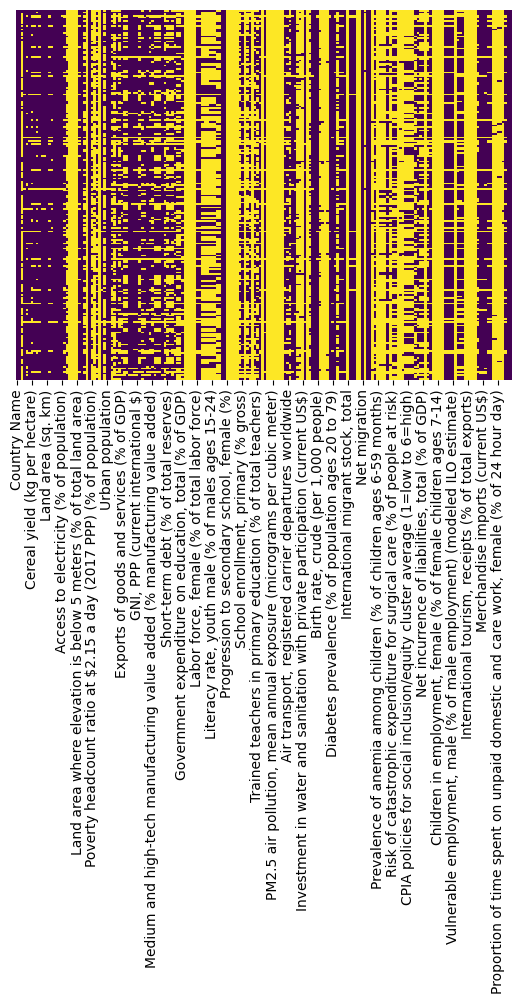

In [14]:
sns.heatmap(combined_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [15]:
missing_pct = (combined_df.isnull().mean() * 100)
missing_pct[missing_pct > 50].sort_values(ascending=False)


Electric power consumption (kWh per capita)                                             100.000000
Ease of doing business rank (1=most business-friendly regulations)                      100.000000
Land area where elevation is below 5 meters (% of total land area)                      100.000000
Energy use (kg of oil equivalent per capita)                                            100.000000
Population living in areas where elevation is below 5 meters (% of total population)    100.000000
                                                                                           ...    
Short-term debt (% of total reserves)                                                    54.629630
Container port traffic (TEU: 20 foot equivalent units)                                   51.851852
Intentional homicides (per 100,000 people)                                               51.851852
Children out of school, primary, male                                                    50.925926
Children o

In [16]:
th = len(combined_df)*0.5
combined_df.dropna(thresh=th, axis=1,inplace=True)

In [17]:
combined_df.shape

(216, 106)

In [18]:
target_col = "Gender Ratio Class"
num_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove(target_col)

cat_cols = combined_df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")
print(f"\nCategorical columns: {cat_cols}")



Numerical columns: 102
Categorical columns: 3

Categorical columns: ['Country Name', 'Region', 'ThirdWorld']


In [19]:
combined_df = combined_df.dropna(subset=[target_col])

In [20]:
combined_df.shape

(186, 106)

<Axes: >

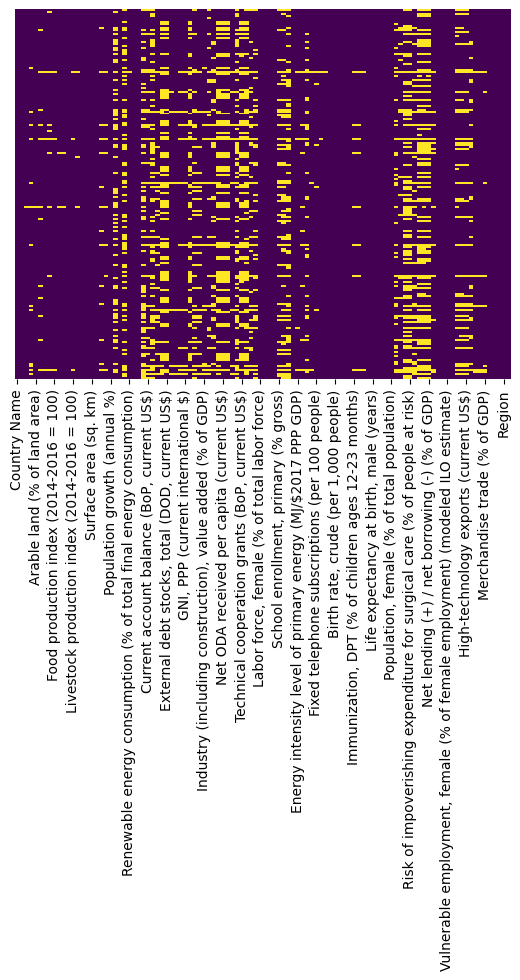

In [21]:
sns.heatmap(combined_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [22]:
missing_pct = (combined_df.isnull().mean() * 100).sort_values(ascending=False)
missing_pct


Risk of impoverishing expenditure for surgical care (% of people at risk)              41.397849
Risk of catastrophic expenditure for surgical care (% of people at risk)               41.397849
Net acquisition of financial assets (% of GDP)                                         40.322581
Net incurrence of liabilities, total (% of GDP)                                        39.784946
Total debt service (% of exports of goods, services and primary income)                39.247312
                                                                                         ...    
Contributing family workers, female (% of female employment) (modeled ILO estimate)     0.000000
Contributing family workers, male (% of male employment) (modeled ILO estimate)         0.000000
Gender Ratio Class                                                                      0.000000
Region                                                                                  0.000000
ThirdWorld                    

In [24]:
threshold = 0.9
corr_matrix = combined_df[num_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
len(to_drop)

21

In [31]:
from scipy.stats import normaltest

def check_normality(df,alpha=0.05):

    stat, p_value = normaltest(df)
    
    if p_value > alpha:
        return 'Yes'
    else:
        return 'No'

results = []
for col in num_cols:
    result = check_normality(combined_df[col])
    results.append({'Column': col, 'Normal (α=0.05)': result})

summary_df = pd.DataFrame(results)
print(f"\nTotal columns tested: {len(summary_df)}")

normal_count = (summary_df['Normal (α=0.05)'] == 'Yes').sum()
not_normal_count = (summary_df['Normal (α=0.05)'] == 'No').sum()

print(f"  - Normally distributed:     {normal_count}")
print(f"  - NOT normally distributed: {not_normal_count}")


display(summary_df)


Total columns tested: 102
  - Normally distributed:     2
  - NOT normally distributed: 100


d:\stat-aj-supaporn\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1687: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis, _no_deco=True)
d:\stat-aj-supaporn\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1792: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False, _no_deco=True)


,Column,Normal (α=0.05)
0,Year,No
1,Agricultural land (% of land area),No
2,"Agriculture, forestry, and fishing, value adde...",No
3,Arable land (% of land area),No
4,Cereal yield (kg per hectare),No
...,...,...
97,Merchandise exports (current US$),No
98,Merchandise imports (current US$),No
99,Merchandise trade (% of GDP),No
100,"Contributing family workers, female (% of fema...",No


In [25]:
combined_df.describe()

,Year,Agricultural land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)",Arable land (% of land area),Cereal yield (kg per hectare),Crop production index (2014-2016 = 100),Fertilizer consumption (kilograms per hectare of arable land),Food production index (2014-2016 = 100),Forest area (% of land area),Forest area (sq. km),...,Fuel exports (% of merchandise exports),High-technology exports (% of manufactured exports),High-technology exports (current US$),Medium and high-tech exports (% manufactured exports),Merchandise exports (current US$),Merchandise imports (current US$),Merchandise trade (% of GDP),"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)",Gender Ratio Class
count,186.0,185.000000,173.000000,185.000000,174.000000,183.000000,177.000000,183.000000,184.000000,1.840000e+02,...,147.000000,149.000000,1.530000e+02,150.000000,1.810000e+02,1.810000e+02,178.000000,186.000000,186.000000,186.000000
mean,2021.0,38.850703,10.348960,14.693568,3860.261494,108.507869,162.626780,108.957104,31.813098,2.186054e+05,...,15.468027,10.182685,2.251191e+10,32.771200,1.208217e+11,1.225748e+11,68.943764,11.520538,5.112204,2.908602
std,0.0,21.956279,10.117734,13.898748,3479.840416,19.769646,275.873868,17.169299,23.453420,8.018824e+05,...,24.085379,12.532632,8.982382e+10,23.137856,3.353440e+11,3.436198e+11,46.359128,15.803034,7.132315,1.447171
min,2021.0,0.500000,0.030000,0.130000,16.300000,53.890000,0.010000,65.740000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.040000,1.600000e+07,1.660000e+08,13.670000,0.000000,0.000000,1.000000
25%,2021.0,19.890000,2.240000,4.120000,1658.075000,97.300000,20.680000,100.225000,11.390000,5.070875e+03,...,0.805000,1.600000,1.279721e+07,11.765000,2.726000e+09,4.376000e+09,40.975000,0.725000,0.435000,2.000000
50%,2021.0,40.280000,7.150000,10.990000,3120.400000,105.130000,98.080000,106.130000,31.125000,2.725443e+04,...,3.690000,6.070000,1.328188e+08,30.145000,1.054700e+10,1.385700e+10,57.215000,3.600000,1.810000,3.000000
75%,2021.0,54.710000,15.550000,21.890000,5124.700000,117.165000,177.250000,117.410000,48.715000,1.264917e+05,...,19.000000,14.240000,3.561400e+09,50.322500,7.164600e+10,7.445300e+10,79.182500,16.155000,7.830000,4.000000
max,2021.0,81.890000,57.450000,62.300000,30400.200000,198.070000,2146.250000,179.910000,97.330000,8.153116e+06,...,94.630000,70.550000,9.360000e+11,79.920000,3.320000e+12,2.940000e+12,374.640000,67.760000,42.800000,5.000000


In [26]:
combined_df[num_cols].var().sort_values()

Year                                                                        0.000000e+00
Price level ratio of PPP conversion factor (GDP) to market exchange rate    5.197518e-02
Fertility rate, total (births per woman)                                    1.588761e+00
Population growth (annual %)                                                1.806171e+00
Military expenditure (% of GDP)                                             1.806809e+00
                                                                                ...     
Total reserves (includes gold, current US$)                                 1.082840e+23
Merchandise exports (current US$)                                           1.124556e+23
Merchandise imports (current US$)                                           1.180746e+23
GDP (current US$)                                                           5.193533e+24
GNI, PPP (current international $)                                          9.237409e+24
Length: 102, dtype: f

In [27]:


# --- GLOBAL SETUP ---
cat_cols.remove("Country Name")
X_raw = combined_df[num_cols + cat_cols].copy()
y_raw = combined_df[target_col].copy()

print(f"Dataset Shape: {X_raw.shape}")
print(f"Numeric Cols: {len(num_cols)} | Categorical Cols: {len(cat_cols)}")

def remove_highly_correlated_features(X_train, X_test, threshold=0.90):
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"  > Dropping {len(to_drop)} highly correlated features (> {threshold})")
    return X_train.drop(columns=to_drop), X_test.drop(columns=to_drop)



Dataset Shape: (186, 104)
Numeric Cols: 102 | Categorical Cols: 2


---
## WORKFLOW 1: Decision Tree + Correlation Filter + Forward Selection


# Preprocessing
split + handling missing values + label encoding + numeric outlier capping + scaling

In [28]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

X_train_1_proc = X_train_1.copy()
X_test_1_proc = X_test_1.copy()

# Categorical Handling 
for col in cat_cols:
    if col in X_train_1_proc.columns:
        mode_val = X_train_1_proc[col].mode()[0]
        X_train_1_proc[col] = X_train_1_proc[col].fillna(mode_val)
        X_test_1_proc[col] = X_test_1_proc[col].fillna(mode_val)
        
        le = LabelEncoder()
        le.fit(X_train_1_proc[col].astype(str))
        known_labels = set(le.classes_)
        train_mode_str = X_train_1_proc[col].astype(str).mode()[0]
        
        X_test_1_proc[col] = X_test_1_proc[col].astype(str).apply(
            lambda x: x if x in known_labels else train_mode_str
        )
        X_train_1_proc[col] = le.transform(X_train_1_proc[col].astype(str))
        X_test_1_proc[col] = le.transform(X_test_1_proc[col])   

# Numeric Handling 
num_cols_actual = [c for c in num_cols if c in X_train_1_proc.columns]
for col in num_cols_actual:
    med = X_train_1_proc[col].median()
    X_train_1_proc[col] = X_train_1_proc[col].fillna(med)
    X_test_1_proc[col] = X_test_1_proc[col].fillna(med)
    # Outlier Capping 
    lower = X_train_1_proc[col].quantile(0.05)
    upper = X_train_1_proc[col].quantile(0.95)
    X_train_1_proc[col] = X_train_1_proc[col].clip(lower, upper)
    X_test_1_proc[col] = X_test_1_proc[col].clip(lower, upper)
scaler_1 = StandardScaler()
X_train_1_proc[num_cols_actual] = scaler_1.fit_transform(X_train_1_proc[num_cols_actual])
X_test_1_proc[num_cols_actual] = scaler_1.transform(X_test_1_proc[num_cols_actual])

# Feature Selection
Correlation Filtering + Forward Selection

In [29]:
X_train_1_proc, X_test_1_proc = remove_highly_correlated_features(X_train_1_proc, X_test_1_proc, threshold=0.90)

f_scores, p_values = f_classif(X_train_1_proc, y_train_1) 
feature_scores = pd.Series(f_scores, index=X_train_1_proc.columns)

n_top_features = 25
top_features = feature_scores.nlargest(n_top_features).index.tolist()

  > Dropping 15 highly correlated features (> 0.9)


d:\stat-aj-supaporn\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
d:\stat-aj-supaporn\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# Modeling
Decision Tree

In [30]:

X_train_1_sel = X_train_1_proc[top_features]
X_test_1_sel = X_test_1_proc[top_features]


model_1 = DecisionTreeClassifier(criterion='gini', random_state=42)
model_1.fit(X_train_1_sel, y_train_1)
y_pred_1 = model_1.predict(X_test_1_sel)



# Evaluation

In [31]:
f1_wf1 = f1_score(y_test_1, y_pred_1, average='macro', zero_division=0)
acc_wf1 = accuracy_score(y_test_1, y_pred_1)


print(f"  Accuracy:  {acc_wf1:.4f}")
print(f"  F1-Score:  {f1_wf1:.4f}")
print("Classification Report:")
print(classification_report(y_test_1, y_pred_1, zero_division=0))

  Accuracy:  0.3947
  F1-Score:  0.3691
Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.57      0.53         7
         2.0       0.38      0.42      0.40        12
         3.0       0.20      0.17      0.18         6
         4.0       0.33      0.25      0.29         4
         5.0       0.44      0.44      0.44         9

    accuracy                           0.39        38
   macro avg       0.37      0.37      0.37        38
weighted avg       0.39      0.39      0.39        38



---
## WORKFLOW 2: KNN + One hot encoding + Correlation filter 

# Preprocessing
split + handling missing values + one hot encoding + numeric outlier capping + scaling

In [32]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

X_train_2_proc = X_train_2.copy()
X_test_2_proc = X_test_2.copy()

num_cols_actual = [c for c in num_cols if c in X_train_2_proc.columns]
for col in num_cols_actual:
    mean_val = X_train_2_proc[col].mean()
    X_train_2_proc[col] = X_train_2_proc[col].fillna(mean_val)
    X_test_2_proc[col] = X_test_2_proc[col].fillna(mean_val)

    lower = X_train_2_proc[col].quantile(0.01)
    upper = X_train_2_proc[col].quantile(0.99)
    X_train_2_proc[col] = X_train_2_proc[col].clip(lower, upper)
    X_test_2_proc[col] = X_test_2_proc[col].clip(lower, upper)
    

scaler_2 = StandardScaler()
X_train_2_proc[num_cols_actual] = scaler_2.fit_transform(X_train_2_proc[num_cols_actual])
X_test_2_proc[num_cols_actual] = scaler_2.transform(X_test_2_proc[num_cols_actual])

cat_cols_actual = [c for c in cat_cols if c in X_train_2_proc.columns]
if len(cat_cols_actual) > 0:

    for col in cat_cols_actual:
        mode_val = X_train_2_proc[col].mode()[0]
        X_train_2_proc[col] = X_train_2_proc[col].fillna(mode_val).astype(str)
        X_test_2_proc[col] = X_test_2_proc[col].fillna(mode_val).astype(str)
    
    X_train_2_proc = pd.get_dummies(X_train_2_proc, columns=cat_cols_actual, drop_first=False)
    X_test_2_proc = pd.get_dummies(X_test_2_proc, columns=cat_cols_actual, drop_first=False)
    
    X_train_2_proc, X_test_2_proc = X_train_2_proc.align(X_test_2_proc, join='left', axis=1, fill_value=0)


# Feature Selection
Correlation filter

In [33]:
X_train_2_proc, X_test_2_proc = remove_highly_correlated_features(X_train_2_proc, X_test_2_proc, threshold=0.90)

  > Dropping 16 highly correlated features (> 0.9)


# Modeling
KNN

In [34]:
model_2 = KNeighborsClassifier(
    n_neighbors=5,
    metric='manhattan'
)
model_2.fit(X_train_2_proc, y_train_2)
y_pred_2 = model_2.predict(X_test_2_proc)

# Evaluation

In [35]:
f1_wf2 = f1_score(y_test_2, y_pred_2, average='macro', zero_division=0)
acc_wf2 = accuracy_score(y_test_2, y_pred_2)
print(f"  Accuracy:  {acc_wf2:.4f}")
print(f"  F1-Score:  {f1_wf2:.4f}")
print(classification_report(y_test_2, y_pred_2, zero_division=0))

  Accuracy:  0.3947
  F1-Score:  0.4079
              precision    recall  f1-score   support

         1.0       0.50      0.57      0.53         7
         2.0       0.38      0.42      0.40        12
         3.0       0.25      0.33      0.29         6
         4.0       0.60      0.75      0.67         4
         5.0       0.25      0.11      0.15         9

    accuracy                           0.39        38
   macro avg       0.40      0.44      0.41        38
weighted avg       0.38      0.39      0.38        38



---
## WORKFLOW 3: Random Forest + RFE + Correlation Filter 

# Preprocessing
split + handling missing values + label encoding + numeric outlier capping + scaling

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

X_train_3_proc = X_train_3.copy()
X_test_3_proc = X_test_3.copy()

for col in cat_cols:
    if col in X_train_3_proc.columns:
        mode_val = X_train_3_proc[col].mode()[0]
        X_train_3_proc[col] = X_train_3_proc[col].fillna(mode_val)
        X_test_3_proc[col] = X_test_3_proc[col].fillna(mode_val)
        
        le = LabelEncoder()
        le.fit(X_train_3_proc[col].astype(str))
        known_labels = set(le.classes_)
        train_mode_str = X_train_3_proc[col].astype(str).mode()[0]
        X_test_3_proc[col] = X_test_3_proc[col].astype(str).apply(
            lambda x: x if x in known_labels else train_mode_str
        )
        X_train_3_proc[col] = le.transform(X_train_3_proc[col].astype(str))
        X_test_3_proc[col] = le.transform(X_test_3_proc[col])

num_cols_actual = [c for c in num_cols if c in X_train_3_proc.columns]
for col in num_cols_actual:
    med = X_train_3_proc[col].median()
    X_train_3_proc[col] = X_train_3_proc[col].fillna(med)
    X_test_3_proc[col] = X_test_3_proc[col].fillna(med)
    lower = X_train_3_proc[col].quantile(0.01)
    upper = X_train_3_proc[col].quantile(0.99)
    X_train_3_proc[col] = X_train_3_proc[col].clip(lower, upper)
    X_test_3_proc[col] = X_test_3_proc[col].clip(lower, upper)

scaler_3 = StandardScaler()
X_train_3_proc[num_cols_actual] = scaler_3.fit_transform(X_train_3_proc[num_cols_actual])
X_test_3_proc[num_cols_actual] = scaler_3.transform(X_test_3_proc[num_cols_actual])

# Feature Selection
Correlation filter + RFE

In [37]:
X_train_3_proc, X_test_3_proc = remove_highly_correlated_features(X_train_3_proc, X_test_3_proc, threshold=0.90)

n_rfe_features = 20
rfe_base = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rfe_base, n_features_to_select=n_rfe_features, step=3)
X_train_3_sel = rfe.fit_transform(X_train_3_proc, y_train_3)
X_test_3_sel = rfe.transform(X_test_3_proc)



  > Dropping 17 highly correlated features (> 0.9)


# Modeling
Random Forest

In [38]:
model_3 = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    random_state=42
)
model_3.fit(X_train_3_sel, y_train_3)
y_pred_3 = model_3.predict(X_test_3_sel)

# Evaluation

In [39]:
f1_wf3 = f1_score(y_test_3, y_pred_3, average='macro', zero_division=0)
acc_wf3 = accuracy_score(y_test_3, y_pred_3)

print(f"  Accuracy:  {acc_wf3:.4f}")
print(f"  F1-Score:  {f1_wf3:.4f}")
print(classification_report(y_test_3, y_pred_3, zero_division=0))

  Accuracy:  0.4737
  F1-Score:  0.4852
              precision    recall  f1-score   support

         1.0       0.67      0.57      0.62         7
         2.0       0.35      0.50      0.41        12
         3.0       1.00      0.17      0.29         6
         4.0       0.60      0.75      0.67         4
         5.0       0.44      0.44      0.44         9

    accuracy                           0.47        38
   macro avg       0.61      0.49      0.49        38
weighted avg       0.56      0.47      0.46        38



---
# Summarize

In [40]:
print(f" WF2 with WF1 improvement: F1 {f1_wf2 - f1_wf1:+.4f}")
print(f" WF3 with WF1 improvement: F1 {f1_wf3 - f1_wf1:+.4f}")
print(f" WF3 with WF2 improvement: F1 {f1_wf3 - f1_wf2:+.4f}")
comparison = pd.DataFrame({
    'Workflow': ['WF1 (DecTree)', 'WF2 (KNN)', 'WF3 (RF)'],
    'Accuracy': [acc_wf1, acc_wf2, acc_wf3],
    'F1-Score': [f1_wf1, f1_wf2, f1_wf3]
})
print(comparison)



 WF2 with WF1 improvement: F1 +0.0389
 WF3 with WF1 improvement: F1 +0.1161
 WF3 with WF2 improvement: F1 +0.0773
        Workflow  Accuracy  F1-Score
0  WF1 (DecTree)  0.394737  0.369062
1      WF2 (KNN)  0.394737  0.407912
2       WF3 (RF)  0.473684  0.485201


Confusion Matrix:


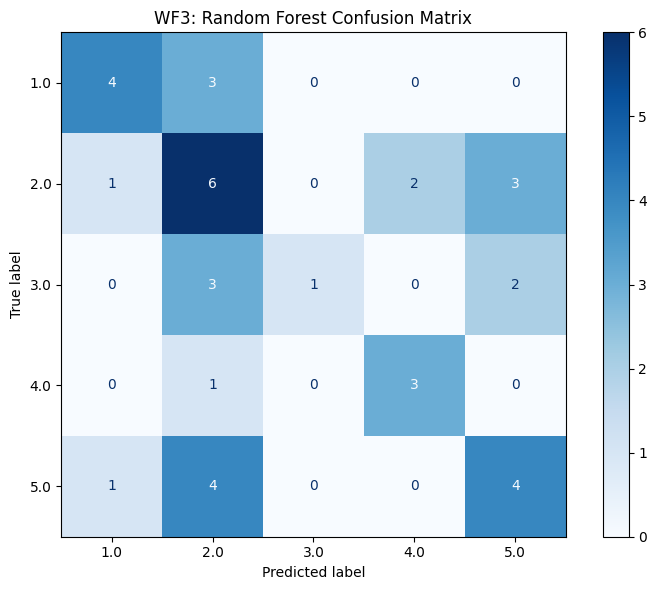

Top 10 Feature Importances (RFE Selected):
                                              Feature  Importance
5                                    Rural population    0.078488
11                              GDP growth (annual %)    0.057438
13  Medium and high-tech manufacturing value added...    0.056006
14  Price level ratio of PPP conversion factor (GD...    0.055131
2                       Cereal yield (kg per hectare)    0.054450
6            Rural population (% of total population)    0.053041
4                                Forest area (sq. km)    0.052809
9                     External debt stocks (% of GNI)    0.050796
17  Proportion of seats held by women in national ...    0.050772
16         Population, female (% of total population)    0.048760


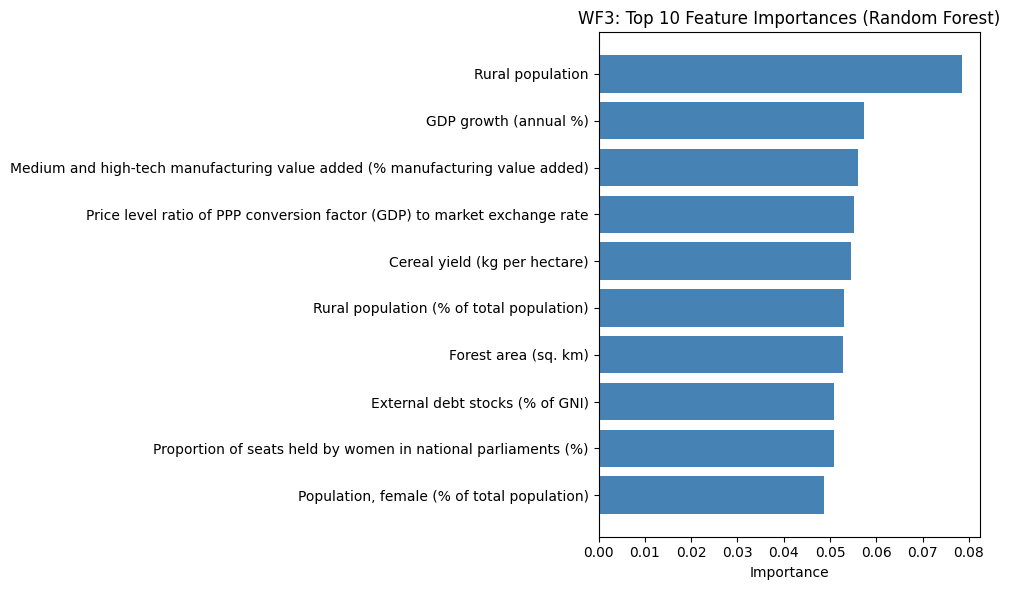

Classification Report:
              precision    recall  f1-score   support

         1.0       0.67      0.57      0.62         7
         2.0       0.35      0.50      0.41        12
         3.0       1.00      0.17      0.29         6
         4.0       0.60      0.75      0.67         4
         5.0       0.44      0.44      0.44         9

    accuracy                           0.47        38
   macro avg       0.61      0.49      0.49        38
weighted avg       0.56      0.47      0.46        38



In [41]:

print("Confusion Matrix:")
cm = confusion_matrix(y_test_3, y_pred_3)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_3.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('WF3: Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

print("Top 10 Feature Importances (RFE Selected):")
feature_names_rfe = X_train_3_proc.columns[rfe.support_].tolist()
importances = model_3.feature_importances_

# Sort by importance
importance_df = pd.DataFrame({
    'Feature': feature_names_rfe,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print(importance_df.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_10 = importance_df.head(10)
ax.barh(top_10['Feature'], top_10['Importance'], color='steelblue')
ax.set_xlabel('Importance')
ax.set_title('WF3: Top 10 Feature Importances (Random Forest)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_test_3, y_pred_3, zero_division=0))

